In [1]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import math, random, re
import time
import pickle
from Bio import SeqIO

In [12]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Bidirectional, RepeatVector, Reshape, LSTM
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Lambda, Dropout,Activation, TimeDistributed
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

In [3]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

In [4]:
def filter_seq(seq):
    '''Filter away ambiguous character containing sequences.'''
    if set(list(seq)) <= AA_SET:
        return(seq)
    else:
        return(None)

In [5]:
def seq2onehot(seq_list):
    '''
    Translate a list of amino acid sequences into a 3D tensor with onehot encodings.
    NB. all sequences must be of equal length.
    '''
    seqlen = len(seq_list[0])
    assert(not [True for s in seq_list if len(s) != seqlen])
    onehot_tensor = np.zeros((len(seq_list), seqlen, len(AA_SET)))
    for i, seq in enumerate(seq_list):
        for j, a in enumerate(seq):
            onehot_tensor[i][j][AA_DICT[a]] = 1
    return(onehot_tensor)

In [6]:
def onehot2seq(onehot_tensor):
    '''
    Translate a 3D tensor with onehot encodings to a list of amino acid sequences.
    '''
    seq_list = list()
    for i in range(onehot_tensor.shape[0]):
        seq = list()
        for j in range(onehot_tensor.shape[1]):
            seq.append(AA_DICT_REV[onehot_tensor[i][j].argmax()])
        seq_list.append(''.join(seq))
    return(seq_list)

In [8]:
# Read in some sequences:
MAX_SEQS = 1000
fnam = '../spurf_heavy_chain_AHo.fasta'
seq_list = list()
for i, record in enumerate(SeqIO.parse(fnam, 'fasta')):
    if i >= MAX_SEQS:
        break
    seq_list.append(str(record.seq))
print('Input data has {} sequences.'.format(len(seq_list)))

Input data has 1000 sequences.


In [9]:
# Transform to onehot:
onehot_tensor = seq2onehot(seq_list)
print('Onehot encoded tensor has this shape: {}'.format(onehot_tensor.shape))

Onehot encoded tensor has this shape: (1000, 149, 21)


In [10]:
# Various network definitions:
batch_size = 100
input_shape = onehot_tensor.shape[1:]
input_total_dim = np.array(input_shape).prod()

latent_dim = 10
lstm_nodes = 149
#lstm_nodes = 30

epsilon_std = 1.0
def sampling(args):
    '''This function draws a sample from the multinomial defined by the latent variables.'''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

def vae_loss(io_encoder, io_decoder):
    '''The loss function is the sum of the cross-entropy and KL divergence.'''
    # Notice that "objectives.categorical_crossentropy(io_encoder, io_decoder)" is a vector so it is averaged:
    xent_loss = input_total_dim * K.mean(objectives.categorical_crossentropy(io_encoder, io_decoder))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return(xent_loss + kl_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 149, 21)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 149, 298)          203832    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 298)               534016    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2990      
Total params: 740,838
Trainable params: 740,838
Non-trainable params: 0
_________________________________________________________________


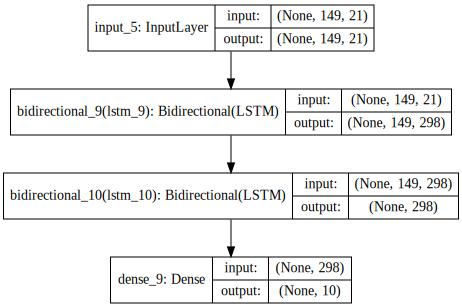

In [16]:
# Encoding layers:
io_encoder = Input(shape=input_shape)
lstm_encoder1 = Bidirectional(LSTM(lstm_nodes, return_sequences=True, recurrent_dropout=0.2), merge_mode='concat')(io_encoder)
lstm_encoder2 = Bidirectional(LSTM(lstm_nodes, return_sequences=False, recurrent_dropout=0.2), merge_mode='concat')(lstm_encoder1)


# Latent layers:
z_mean = Dense(latent_dim)(lstm_encoder2)
z_log_var = Dense(latent_dim)(lstm_encoder2)
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

encoder = Model(io_encoder, z_mean)
encoder.summary()
plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 149, 10)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 149, 298)          190720    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 298)               534016    
_________________________________________________________________
dense_13 (Dense)             (None, 3129)              935571    
_________________________________________________________________
reshape_2 (Reshape)          (None, 149, 21)           0         
Total params: 1,660,307
Trainable params: 1,660,307
Non-trainable params: 0
_________________________________________________________________


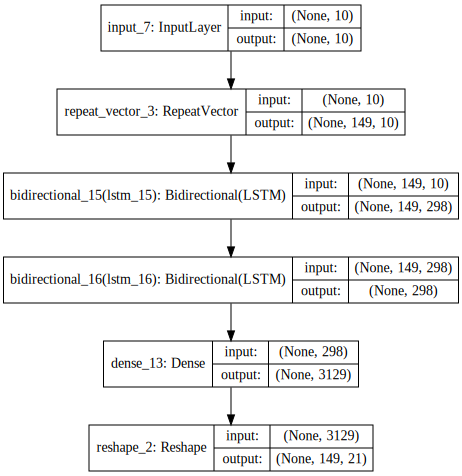

In [19]:
# Decoding layers:
rep_decoder = RepeatVector(input_shape[0])
lstm_decoder1 = Bidirectional(LSTM(lstm_nodes, return_sequences=True, recurrent_dropout=0.2), merge_mode='concat')
lstm_decoder2 = Bidirectional(LSTM(lstm_nodes, return_sequences=False, recurrent_dropout=0.2), merge_mode='concat')
decoder_out = Dense(input_total_dim, activation='sigmoid')
reshape2input = Reshape(input_shape)
io_decoder = reshape2input(decoder_out(lstm_decoder2(lstm_decoder1(rep_decoder(z)))))


io_z = Input(shape=(latent_dim,))
io_decoder_means = reshape2input(decoder_out(lstm_decoder2(lstm_decoder1(rep_decoder(io_z)))))
decoder = Model(io_z, io_decoder_means)
decoder.summary()
plot_model(decoder, to_file='decoder.svg', show_shapes=True)
SVG(model_to_dot(decoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 149, 21)       0                                            
____________________________________________________________________________________________________
bidirectional_49 (Bidirectional) (None, 149, 60)       12480       input_21[0][0]                   
____________________________________________________________________________________________________
bidirectional_50 (Bidirectional) (None, 60)            21840       bidirectional_49[0][0]           
____________________________________________________________________________________________________
dense_26 (Dense)                 (None, 10)            610         bidirectional_50[0][0]           
___________________________________________________________________________________________

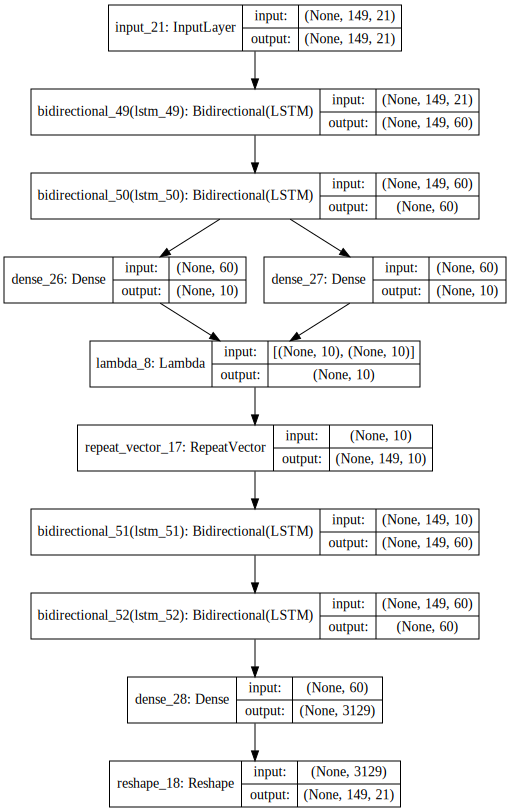

In [117]:
vae = Model(io_encoder, io_decoder)
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [111]:
# Split dataset into train/test:
x_train, x_test = train_test_split(onehot_tensor, test_size=0.1, shuffle=True)
sl = len(x_train) // (batch_size*10)
sl = sl // 10
x_train = x_train[:(sl*batch_size*10)]

In [ ]:
nb_epoch = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
vae_log = vae.fit(x_train,
                  x_train,  # VAE is unsupervised so y=X
                  shuffle=True,
                  epochs=nb_epoch,
                  batch_size=batch_size,
                  validation_split=0.1,
                  callbacks=[early_stopping])

Train on 129600 samples, validate on 14400 samples
Epoch 1/2
129600/129600 [==============================] - 1338s - loss: 2997.4940 - val_loss: 2791.0774
Epoch 2/2
 64600/129600 [=============>................] - ETA: 652s - loss: 2790.6839

In [ ]:
# loss before fail: 2636

In [ ]:
vae.save('lstm_vae.h5')
#vae.load_weights('lstm_vae.h5')

In [44]:
x_test_encoded = encoder.predict(x_test)
print(x_test_encoded.shape)

(1000, 10)


In [45]:
x_test_decoded = decoder.predict(x_test_encoded)
print(x_test_decoded.shape)

(1000, 149, 21)


In [46]:
# Normalize decoded output:
for i in range(len(x_test_decoded)):
    x_test_decoded[i] = normalize(x_test_decoded[i], axis=1, norm='l1')
print('This "{}" should be close to {}.'.format(sum(sum(x_test_decoded[0])), x_test_decoded.shape[1]))

This "148.9999896287918" should be close to 149.


In [47]:
x_test_decoded_onehot = np.zeros(x_test_decoded.shape)
for i in range(x_test_decoded.shape[0]):
    for j in range(x_test_decoded.shape[1]):
        mi = x_test_decoded[i][j].argmax()
        x_test_decoded_onehot[i][j][mi] = 1

In [48]:
x_test_decoded_onehot[1][0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  

In [49]:
seqs_test = onehot2seq(x_test)

In [50]:
seqs_test_decoded = onehot2seq(x_test_decoded_onehot)

In [51]:
for i in range(10):
    print(seqs_test[i])
    print(seqs_test_decoded[i])

QVQLVQS-GAEVKKPGASVKVSCKASG-YTFTN-----YGISWVRQAPGQGLEWMGWISAY---NGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAMYYCASVCSTT-------------------SCQLDYWGQGTLVTVSS
QVQLVES-GGGLVKPGGSLRLSCAASG-FTFSS-----YAMSWVRQAPGKGLEWVGVISY----GGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDGGGG-------------------YYGFDYWGQGTLVTVSS
EVQLLES-GGGLVQPGGSLRLSCAASG-FTFSS-----YAMSWVRQAPGKGLEWVSAISGS---GGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARKTVVTP------------------IPYFDYWGQGTLVTVSS
QVQLVES-GGGLVKPGGSLRLSCAASG-FTFSS-----YAMSWVRQAPGKGLEWVGVISY----GGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDGGGG-------------------YYGFDYWGQGTLVTVSS
QVQLVQS-GAEVKKAGSSVKVSCKASG-GTLSS-----YVISWVRQAPGQGLEWMGRIIPV---LNRTNYAQKFQGRVTVTADKSTSTAYMELSSLRFDDTAVYYCARDNSGW--------------------SLHDYWGQGTLVTVSS
QVQLVES-GGGLVKPGGSLRLSCAASG-FTFSS-----YAMSWVRQAPGKGLEWVGVISY----GGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDGGGG-------------------YYGFDYWGQGTLVTVSS
EVQLVES-GGGLVKPGGSLRLSCAASG-FTFSS-----YSMNWVRQAPGKGLEWVSSISSS---SSYIYYADSVKGRFTISRDNAKNSLYLQMNSLRAED

In [52]:
x_test_encoded

array([[-1.69093931, -0.5660376 ,  2.72131729, ..., -7.01782131,
        -2.86374974,  3.75052333],
       [-1.69010699, -0.56717044,  2.72074556, ..., -7.01766157,
        -2.8636024 ,  3.7507093 ],
       [-1.69093883, -0.56603771,  2.72131753, ..., -7.01782084,
        -2.8637495 ,  3.75052333],
       ..., 
       [-1.69010699, -0.56717044,  2.72074556, ..., -7.01766157,
        -2.8636024 ,  3.7507093 ],
       [-1.69011486, -0.56716675,  2.72073889, ..., -7.01766109,
        -2.86360621,  3.75072026],
       [-1.690871  , -0.5660916 ,  2.72136807, ..., -7.01786423,
        -2.86370587,  3.75039577]], dtype=float32)

In [53]:
kkg = np.random.normal(0, 1, size=(100,10))

In [54]:
kkgd = decoder.predict(kkg)

In [55]:
# Normalize decoded output:
for i in range(len(kkgd)):
    kkgd[i] = normalize(kkgd[i], axis=1, norm='l1')
print('This "{}" should be close to {}.'.format(sum(sum(kkgd[0])), kkgd.shape[1]))

This "148.9999885559082" should be close to 149.


In [56]:
kkgd_onehot = np.zeros(kkgd.shape)
for i in range(kkgd.shape[0]):
    for j in range(kkgd.shape[1]):
        mi = kkgd[i][j].argmax()
        kkgd_onehot[i][j][mi] = 1

In [57]:
kkgd_onehot[0][0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [58]:
l = onehot2seq(kkgd_onehot)

In [59]:
for i, li in enumerate(l):
    print('>', i)
    print(li.replace('-', ''))

> 0
STFAWVIYMWYYIYHTLSQMLQGCYCGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCEGNIQYCPCWFQWFYWCQHLWDWMQKKQMQNTEHPDCDTWWQMMMQMGYSDCYWQCY
> 1
STFAWWVIYMLYYIYCGLSQMLQGCYMCGHWWCRPWMPYHTECYQALISMDLQWQTFWCCKFCKCKNCWGNIQYCNCWFQWCFYWCQHLWDAWMQKKQMMNTEHPDCDTWWQMMMQMGYSDCYWQCY
> 2
STFAWVIYMWYYIYHGLFQMLQGCYMCGHWWCRPWMPYHTYCYQALISMDLQWQTFWCCKFCKCKNCWGNIQYCNCWFQWFYWCQHLWDAWMQKKQMMITEHPDCDTWWQMMMQMGYSDCYWQCY
> 3
STFAWVIYMWYYIYHGLSQMLQGCYMQGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCWGNIQYCNCWFQWFYWCQHLWDWMQKKQMMITEHPDCDTWWQMMMQMGYSDCYWQCY
> 4
STFAWVIYMWYYIYCGLFQMLQGCYMCGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCWGNIQYCNNCWFQWFYWCQDLWDWMQKKQMMITEHPDCDTWWQMMMQMGYSDCYWQCY
> 5
STFAWVIYMWYYIYCGLFQMLQGCYMCGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCEGNIQYCNCWFQWCFYWCQHLWDAWMQKKQMMNTEHPDCDTWWQMMMQMGYSDCYWQCY
> 6
STFAWVIYMWYYIYHGLFQMLQGCYMCGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCWGNIQYCNNCWFQWFYWCQHLWDWMQKKQMMITEHPDCDTWWQMMMQMGYSDCYWQCY
> 7
STFAWVIYMLYYIYCGLFQMLQGCYMCGHWWCRPWMPYHYCYQALISMDLQWQTFWCCKFCKCKNCEGNIQYCNNCWFQWCFYWCQHLWDA